In [ ]:
# Load the dataset
import tensorflow as tf

# Paths
train_dir = "Brain_Tumor/Training"
test_dir  = "Brain_Tumor/Testing"

# Config
img_size = (128, 128)
batch_size = 32

# Load training + validation
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Load test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

# Number of output classes (e.g. glioma, meningioma, pituitary, no tumor)
class_names = train_ds.class_names
num_classes = len(train_ds.class_names)


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please 

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


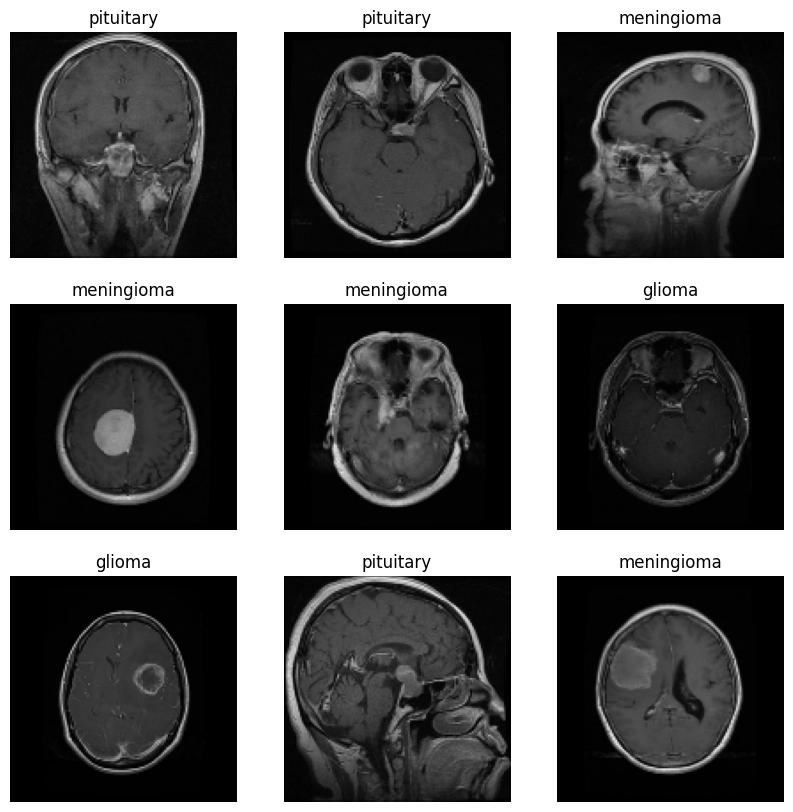

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")

        # Show the whole RGB image instead of forcing grayscale
        plt.imshow(img)        
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


In [3]:
# Normalize (0–255 → 0–1)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [4]:
# Define the CNN
from tensorflow.keras import layers, models

# Building the CNN model step by step
model = models.Sequential([
    # 1st Convolutional layer: extracts low-level features (edges, lines, simple textures)
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    # Pooling layer: reduces image size (downsampling) while keeping important info
    layers.MaxPooling2D((2,2)),

    # 2nd Convolutional layer: learns more complex features (shapes, blobs, corners)
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    # 3rd Convolutional layer: even deeper features (tumor textures, regions)
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    # Fully connected layer: combines all learned features
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

# Show architecture summary: parameters, shapes, etc.
model.summary()


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [6]:
# Train the model
history = model.fit(
    train_ds,              
    validation_data=val_ds,
    epochs=10              
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 656s 4s/step - accuracy: 0.7035 - loss: 0.7454 - val_accuracy: 0.8065 - val_loss: 0.5054
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 687s 5s/step - accuracy: 0.8276 - loss: 0.4514 - val_accuracy: 0.8809 - val_loss: 0.3333
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 565s 4s/step - accuracy: 0.8700 - loss: 0.3360 - val_accuracy: 0.8967 - val_loss: 0.2878
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 637s 4s/step - accuracy: 0.9057 - loss: 0.2494 - val_accuracy: 0.9177 - val_loss: 0.2352
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 471s 3s/step - accuracy: 0.9258 - loss: 0.1983 - val_accuracy: 0.9212 - val_loss: 0.2323
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 532s 4s/step - accuracy: 0.9438 - loss: 0.1529 - val_accuracy: 0.9396 - val_loss: 0.2079
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 649s 5s/step - accuracy: 0.9532 - loss: 0.1250 - val_accuracy: 0.9361 - val_loss: 0.2073
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 644s 4s/step - accuracy: 0.9626 - loss: 0.1011 - val_accu

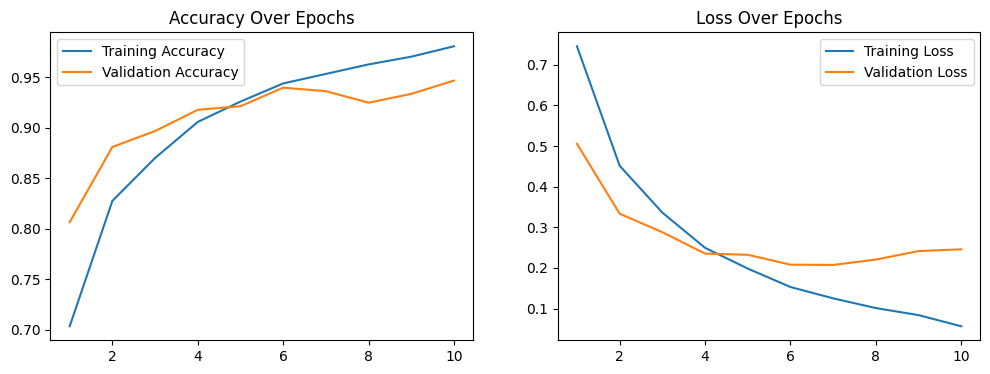

In [7]:
import matplotlib.pyplot as plt

# Extract metrics from training history
acc = history.history["accuracy"]         
val_acc = history.history["val_accuracy"] 
loss = history.history["loss"]            
val_loss = history.history["val_loss"]   
epochs = range(1, len(acc)+1)

plt.figure(figsize=(12,4))

# Plot accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")

# Plot loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss Over Epochs")

plt.show()


In [8]:
# Evaluate model performance on test dataset
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 799ms/step - accuracy: 0.9458 - loss: 0.2433
Test Accuracy: 0.95, Test Loss: 0.24
